# Решение задачи "Анализ ЭКГ-сигналов для диагностики сердечных патологий" для конкурса AI challenge

Оглавление
- Исследование области задачи
- Обработка и анализ данных
- Тестирование различных моделей

## Исследование области задачи
- SCP-ECG - http://masters.donntu.ru/2008/kita/golovach/library/4_ref/pub.html
- стадии инфаркта

## Обработка и анализ данных

Используемые модули

In [1]:
# Для данных
import pandas as pd
import numpy as np

# Для плюшек
import sklearn as sk

# Для красоты
import seaborn as sns
from pprint import pprint

Полезные функции

In [3]:



def get_hr(folder: str, hr_num: str):
    with open(f'data/{folder}/{hr_num}.npy', "rb") as f:
        return np.load(f, allow_pickle=True)

Пример использования

'\nTODO задача про экг на гитхабе\n'

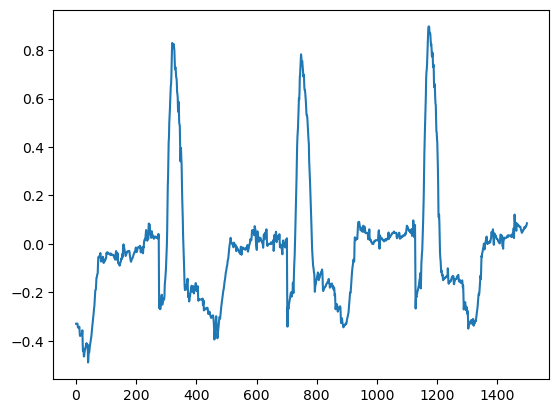

In [4]:
a = get_hr(folder='train', hr_num='15857_hr')
sns.lineplot(data=a.flatten()[:1500])
"""
TODO задача про экг на гитхабе
"""

Загрузка данных

In [5]:
meta = pd.read_csv('data/train/train_meta.csv')
diagnosis = pd.read_csv('data/train/train_gts.csv')

In [ ]:
meta.head(3)

In [ ]:
diagnosis.head(3)

Просмотрим инофрмацию о нашем датасете </br>
https://physionet.org/content/ptb-xl/1.0.3/ - еще здесь нада

In [ ]:
meta.info()

Удалим те данные, которые не несут важной для нас информации

In [6]:
useless_columns = ['ecg_id', 'patient_id', 'nurse', 'site', 'device', 'recording_date', 'filename_lr', 'filename_hr']
meta.drop(columns=useless_columns, inplace=True)

Создадим список тех столбцов, которые возможно не несут важной информации (мы проверим это при обучении)

In [7]:
strange_columns = ['age', 'sex', 'group']

Рассмотрим те столбцы, в которых есть много пропусков

In [ ]:
for column in meta.columns:
    print(f'Column name: {column} {round(meta[column].notna().sum() / len(meta) * 100, 2)}%')
    print(meta[column].value_counts() if len(meta[column].unique()) < 14 else f'so much unique values\n{meta[column].describe()}')
    print()

На основе этих данных выделим список столбцов с множество недостающих значений

In [8]:
empty_columns = ['height', 'weight', 'heart_axis']
meta.drop(columns=empty_columns, inplace=True)

Удалим те строки, в которых electrodes_problem

In [9]:
meta.drop(meta[meta['electrodes_problems'].notna()].index, inplace=True)
meta.drop(columns=['electrodes_problems'], inplace=True)
meta.drop(1514, inplace=True) # Хех пока

In [10]:
meta = meta.reset_index(drop=True)

In [ ]:
meta.info()

Отдельно рассмотрим столбец report, т.к. его нужно по особому обрабатывать

In [ ]:
reports = meta['report'].tolist()

In [ ]:
print(len(reports))
print(len(list(filter(lambda st: 'unbestÄtigter bericht' in st, reports)))) # неподтвержденные

In [ ]:
import stanza

ppln = stanza.Pipeline('de', processors='tokenize,pos,lemma')

In [ ]:
subrs = set()
prc = 0

for ind, report in enumerate(reports):
    doc = ppln(report)

    signs = ['!', ',', '.', ')', '(', ':']

    lemmas = []

    for sentence in doc.sentences:
        lemmas += [word.lemma if word.lemma not in signs else '' for word in sentence.words]

    
    subrs = subrs.union(set(filter(lambda x: x, lemmas)))
    if prc != round((ind+1)/len(reports)*100,1):
        prc = round((ind+1)/len(reports)*100, 1)
        print(prc)

In [ ]:
print(subrs, len(subrs))

In [ ]:
#TUT

Заменим строки в названиях, так как они малину портят

In [11]:
str_columns = ['infarction_stadium1', 'infarction_stadium2', 'burst_noise', 'pacemaker']

meta = pd.get_dummies(meta, columns=str_columns)

In [15]:
"""
TODO у нас еще остались столбцы baseline_drift static_noise extra_beats, scp_codes с не числовым типом
"""
meta['scp_codes'].unique()

array(["{'NORM': 100.0, 'SR': 0.0}", "{'AFLT': 100.0}",
       "{'IRBBB': 100.0, 'SR': 0.0}", "{'LVH': 100.0, 'SR': 0.0}",
       "{'NORM': 80.0, 'STACH': 0.0}", "{'NDT': 100.0, 'SR': 0.0}",
       "{'ASMI': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",
       "{'NORM': 80.0, 'SR': 0.0}", "{'PACE': 100.0}",
       "{'LAFB': 100.0, 'SR': 0.0}", "{'NST_': 100.0, 'SR': 0.0}",
       "{'NST_': 100.0, 'PVC': 100.0, 'SR': 0.0}",
       "{'CRBBB': 100.0, 'LAFB': 100.0, 'SR': 0.0}",
       "{'IMI': 15.0, 'ABQRS': 0.0, 'SR': 0.0}",
       "{'NDT': 100.0, '1AVB': 100.0, 'SR': 0.0}",
       "{'IMI': 100.0, 'CRBBB': 100.0, 'PAC': 0.0, 'LPR': 0.0, 'QWAVE': 0.0, 'SR': 0.0}",
       "{'NORM': 100.0, 'SARRH': 0.0}",
       "{'LVH': 100.0, 'ISC_': 100.0, 'PVC': 100.0, 'NST_': 0.0, 'AFLT': 0.0, 'SVTAC': 0.0}",
       "{'LAFB': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",
       "{'LVH': 100.0, 'ISC_': 100.0}",
       "{'NORM': 80.0, 'PAC': 0.0, 'SR': 0.0}",
       "{'IRBBB': 80.0, 'SR': 0.0}",
       "{'NORM': 80.0, 'IRBBB': 1

TODO подробно описать каждый оставшийся столбец

In [16]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 2096 non-null   float64
 1   sex                                 2096 non-null   int64  
 2   report                              2096 non-null   object 
 3   scp_codes                           2096 non-null   object 
 4   validated_by                        1239 non-null   float64
 5   second_opinion                      2096 non-null   bool   
 6   initial_autogenerated_report        2096 non-null   bool   
 7   validated_by_human                  2096 non-null   bool   
 8   baseline_drift                      150 non-null    object 
 9   static_noise                        308 non-null    object 
 10  extra_beats                         174 non-null    object 
 11  strat_fold                          2096 no

...

## Тестирование различных моделей

Используемые модули (не точно)

In [ ]:
# Нейронки (какие-то уберем, разобраться сначала, какие для этого подходят)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR

# Посложнее, что успеем сделать
import torch #1
import keras #2

# Метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score